<a href="https://colab.research.google.com/github/santmukhgit/Capstone-Computer-Vision/blob/main/Capstone_Project_Car_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading drive**

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

**Downloading files from S3 Bucket**

In [2]:
!pip install tensorflow

In [3]:
!nvidia-smi

Sun Mar  2 19:04:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:16.0 Off |                    0 |
|  0%   41C    P8             17W /  300W |       1MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os
import tensorflow as tf
import boto3

2025-03-02 19:04:47.948329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-02 19:04:47.973369: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-02 19:04:47.973411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 19:04:47.989019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-02 19:04:48.731463: W tensorflow/compiler/tf

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #suppressing info and warnings

In [6]:
# Enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-03-02 19:04:50.693483: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-02 19:04:50.697538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-02 19:04:50.702146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
tf.config.optimizer.set_jit(True)  # Enable XLA

In [8]:
def download_files_from_bucket(file,bucket):
     '''
     this function is for downloading the files from the bucket to the local instance
     '''    
     bucket_name = bucket
     file_key = file
     local_file_path = file
     s3 = boto3.client('s3')
     s3.download_file(bucket_name, file_key, local_file_path)    
     print(f"File downloaded to {local_file_path}")

In [9]:
download_files_from_bucket('stanford-car-dataset-by-classes-folder.zip','pgp-capstone-project')

File downloaded to stanford-car-dataset-by-classes-folder.zip


In [10]:
zip_file_path = 'stanford-car-dataset-by-classes-folder.zip'
!unzip -oq stanford-car-dataset-by-classes-folder.zip 


In [11]:
!pip install opencv-python

In [12]:
!pip install opencv-python-headless

In [13]:
!pip install pillow


# **Installing and Importing Necessary Libraries**

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches
import cv2
from sklearn.model_selection import train_test_split #for model selection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob # for file path handling
from PIL import Image # For image loading and manipulation
import xml.etree.ElementTree as ET # For handling XML annotations (common for object detection datasets)
from sklearn.preprocessing import LabelEncoder

# **Load the Dataset**

In [15]:
# Define paths
#dataset_path = '/content/drive/My Drive/Colab Notebooks/Capstone_Projects/Project 2 - Car Detection' # Replace with the actual path

# for images
#train_images_path = os.path.join(dataset_path, 'Car Images/Train Images')
#test_images_path = os.path.join(dataset_path, 'Car Images/Test Images')
train_images_path = './car_data/car_data/train'
test_images_path = './car_data/car_data/test'

#for annotations
#train_image_annot_dir_file = pd.read_csv(os.path.join(dataset_path, 'Annotations/Train Annotations.csv'))
#test_image_annot_dir_file = pd.read_csv(os.path.join(dataset_path, 'Annotations/Test Annotation.csv'))
train_image_annot_dir_file = pd.read_csv('anno_train.csv',header=None,names=['Image Name', 'Bounding Box coordinates_xmin', 'Bounding Box coordinates_ymin','Bounding Box coordinates_xmax','Bounding Box coordinates_ymax','Image class'])
test_image_annot_dir_file =pd.read_csv('anno_test.csv',header=None,names=['Image Name', 'Bounding Box coordinates_xmin', 'Bounding Box coordinates_ymin','Bounding Box coordinates_xmax','Bounding Box coordinates_ymax','Image class'])

In [16]:
#train_anno_df.rename(columns={'Bounding Box coordinates': 'Bounding Box coordinates_xmin', 'Unnamed: 2': 'Bounding Box coordinates_ymin','Unnamed: 3': 'Bounding Box coordinates_ymin','Unnamed: 4': 'Bounding Box coordinates_ymax'}, inplace=True)
train_image_annot_dir_file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Image Name                     8144 non-null   object
 1   Bounding Box coordinates_xmin  8144 non-null   int64 
 2   Bounding Box coordinates_ymin  8144 non-null   int64 
 3   Bounding Box coordinates_xmax  8144 non-null   int64 
 4   Bounding Box coordinates_ymax  8144 non-null   int64 
 5   Image class                    8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [17]:
train_image_annot_dir_file.head(5)

,Image Name,Bounding Box coordinates_xmin,Bounding Box coordinates_ymin,Bounding Box coordinates_xmax,Bounding Box coordinates_ymax,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [18]:
#test_anno_df.rename(columns={'Bounding Box coordinates': 'Bounding Box coordinates_xmin', 'Unnamed: 2': 'Bounding Box coordinates_ymin','Unnamed: 3': 'Bounding Box coordinates_ymin','Unnamed: 4': 'Bounding Box coordinates_ymax'}, inplace=True)
test_image_annot_dir_file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Image Name                     8041 non-null   object
 1   Bounding Box coordinates_xmin  8041 non-null   int64 
 2   Bounding Box coordinates_ymin  8041 non-null   int64 
 3   Bounding Box coordinates_xmax  8041 non-null   int64 
 4   Bounding Box coordinates_ymax  8041 non-null   int64 
 5   Image class                    8041 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 377.0+ KB


In [19]:
test_image_annot_dir_file.head(5)

,Image Name,Bounding Box coordinates_xmin,Bounding Box coordinates_ymin,Bounding Box coordinates_xmax,Bounding Box coordinates_ymax,Image class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185


In [20]:
train_class_folders = [f.path for f in os.scandir(train_images_path) if f.is_dir()]
test_class_folders = [f.path for f in os.scandir(test_images_path) if f.is_dir()]
train_image_classes = {} # Dictionary to store training image: class mapping
test_image_classes = {}  # Dictionary to store testing image: class mapping

# Define columns for the Training DataFrame
columns_training = ['Image_Path', 'labels']

# Create an empty DataFrame
df_training = pd.DataFrame(columns=columns_training)

# --- Map filenames in a class for train_image_classes
for class_folder in train_class_folders:
     class_name = os.path.basename(class_folder) # Extract class name from folder name
     #labels_train.append(class_name)
     image_files = glob.glob(os.path.join(class_folder, '*.jpg')) # images are .jpg
     for image_file in image_files:
         train_image_classes[os.path.basename(image_file)] = class_name # Map filename to class
         #image_file_path_training.append(image_file)
         df_training.loc[len(df_training)] = [image_file, class_name]


print(df_training.head(10))

# Define columns for the Testing DataFrame
columns_testing = ['Image_Path', 'labels']

# Create an empty DataFrame
df_testing = pd.DataFrame(columns=columns_testing)

# similar logic for test_images_path and test_image_classes
for class_folder in test_class_folders:
     class_name = os.path.basename(class_folder) # Extract class name from folder name
     #labels_testing.append(class_name)
     image_files = glob.glob(os.path.join(class_folder, '*.jpg')) # images are .jpg
     for image_file in image_files:
         test_image_classes[os.path.basename(image_file)] = class_name # Map filename to class
         #image_file_path_testing.append(image_file)
         df_testing.loc[len(df_testing)] = [image_file, class_name]

print(df_testing.head(10))


# --- Print a few mappings to verify ---
print("Sample Training Image to Class Mappings:")
count = 0
for img_name, class_label in train_image_classes.items():
    print(f"{img_name}: {class_label}")
    count += 1
    if count > 5: break # Print first few only

print("Sample Testing Image to Class Mappings:")
count = 0
for img_name, class_label in test_image_classes.items():
    print(f"{img_name}: {class_label}")
    count += 1
    if count > 5: break # Print first few only


                                          Image_Path                  labels
0  ./car_data/car_data/train/Infiniti QX56 SUV 20...  Infiniti QX56 SUV 2011
1  ./car_data/car_data/train/Infiniti QX56 SUV 20...  Infiniti QX56 SUV 2011
2  ./car_data/car_data/train/Infiniti QX56 SUV 20...  Infiniti QX56 SUV 2011
3  ./car_data/car_data/train/Infiniti QX56 SUV 20...  Infiniti QX56 SUV 2011
4  ./car_data/car_data/train/Infiniti QX56 SUV 20...  Infiniti QX56 SUV 2011
5  ./car_data/car_data/train/Infiniti QX56 SUV 20...  Infiniti QX56 SUV 2011
6  ./car_data/car_data/train/Infiniti QX56 SUV 20...  Infiniti QX56 SUV 2011
7  ./car_data/car_data/train/Infiniti QX56 SUV 20...  Infiniti QX56 SUV 2011
8  ./car_data/car_data/train/Infiniti QX56 SUV 20...  Infiniti QX56 SUV 2011
9  ./car_data/car_data/train/Infiniti QX56 SUV 20...  Infiniti QX56 SUV 2011
                                          Image_Path                  labels
0  ./car_data/car_data/test/Infiniti QX56 SUV 201...  Infiniti QX56 SUV 2011

## **Map Training and Testing Images to Their Classes to its annotations**

Create mappings that associate each image filename with its bounding box annotations.

In [21]:
# ********Definition of the method ********************************
def map_images_to_bboxes(annotations_file):
    """
    Maps image filenames to bounding box annotations from a CSV file.

    Args:
        annotations_file (df): Dataframe of the CSV annotation file.

    Returns:
        dict: A dictionary where keys are image filenames (without extension)
              and values are bounding box tuples (xmin, ymin, xmax, ymax).
    """
    image_bboxes = {}
    try:
        for index, row in annotations_file.iterrows():
                image_name = row['Image Name']
                x_min = row['Bounding Box coordinates_xmin']
                y_min = row['Bounding Box coordinates_ymin']
                x_max = row['Bounding Box coordinates_xmax']
                y_max = row['Bounding Box coordinates_ymax']
                image_class = row['Image class']

                image_bboxes[image_name] = (x_min, y_min, x_max, y_max) # Store bbox as tuple

    except FileNotFoundError:
        print(f"Error: Annotation file not found: {annotations_file}")
    except KeyError as e:
        print(f"Error: Column '{e}' not found in CSV file. Check your CSV column names.")
        print("Expected columns (example): filename, xmin, ymin, xmax, ymax") # Example expected columns

    return image_bboxes

In [22]:
train_image_bboxes = map_images_to_bboxes(train_image_annot_dir_file)
test_image_bboxes = map_images_to_bboxes(test_image_annot_dir_file)

# --- Print a few mappings to verify for Training images ---
print("\nSample Training Image to Bounding Box Mappings (DF):")
count = 0
for img_name, bbox in train_image_bboxes.items():
    print(f"{img_name}: {bbox}")
    count += 1
    if count > 5: break

# --- Print a few mappings to verify  testing images---
print("\nSample Testing Image to Bounding Box Mappings (DF):")
count = 0
for img_name, bbox in test_image_bboxes.items():
    print(f"{img_name}: {bbox}")
    count += 1
    if count > 5: break


Sample Training Image to Bounding Box Mappings (DF):
00001.jpg: (39, 116, 569, 375)
00002.jpg: (36, 116, 868, 587)
00003.jpg: (85, 109, 601, 381)
00004.jpg: (621, 393, 1484, 1096)
00005.jpg: (14, 36, 133, 99)
00006.jpg: (259, 289, 515, 416)

Sample Testing Image to Bounding Box Mappings (DF):
00001.jpg: (30, 52, 246, 147)
00002.jpg: (100, 19, 576, 203)
00003.jpg: (51, 105, 968, 659)
00004.jpg: (67, 84, 581, 407)
00005.jpg: (140, 151, 593, 339)
00006.jpg: (20, 77, 420, 301)


# ***Display Images with Bounding Box ***

For Training Images


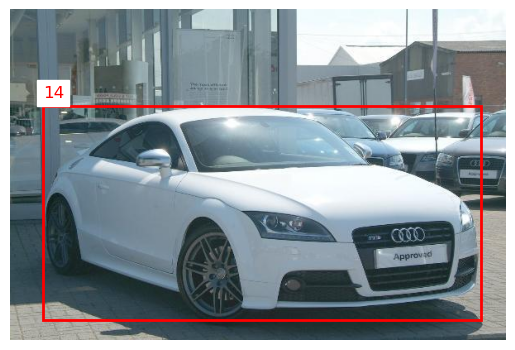

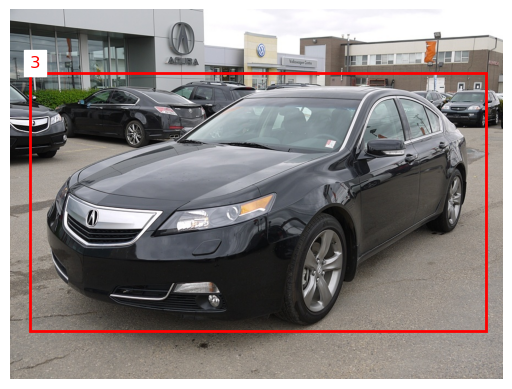

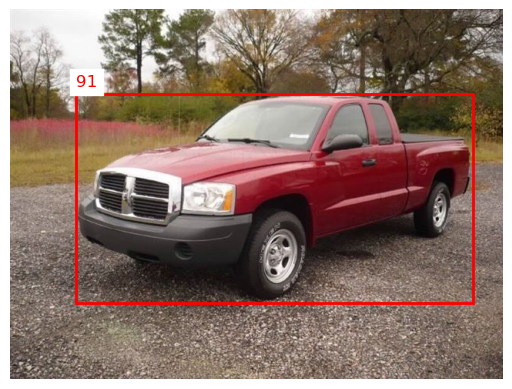

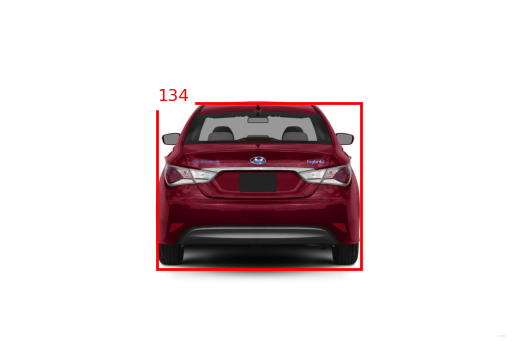

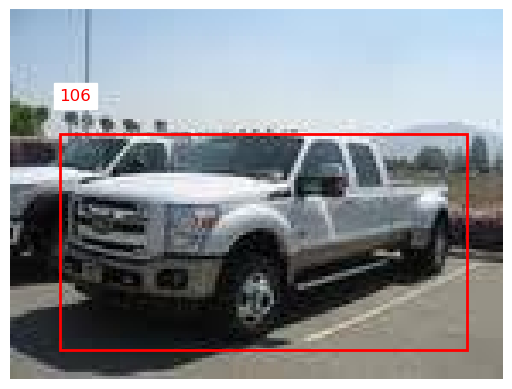

Displayed 5 training images with bounding boxes.
For Testing Images


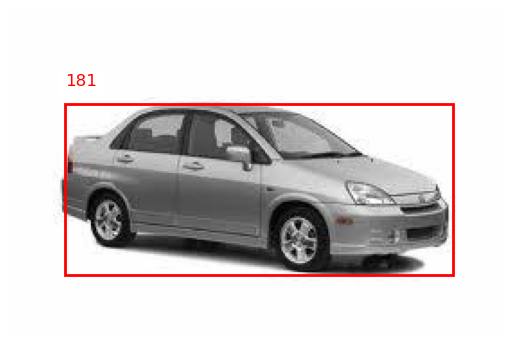

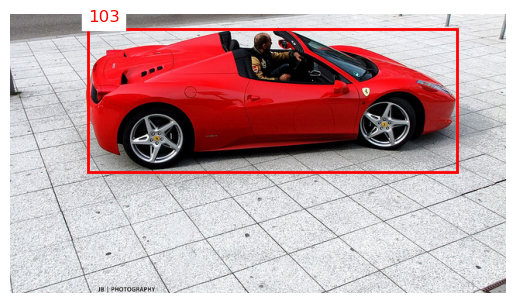

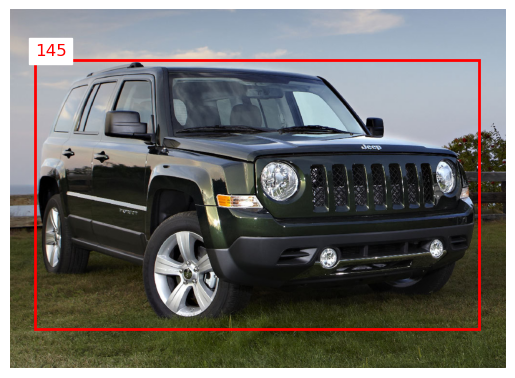

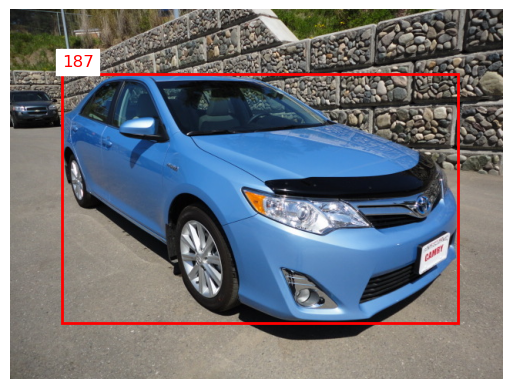

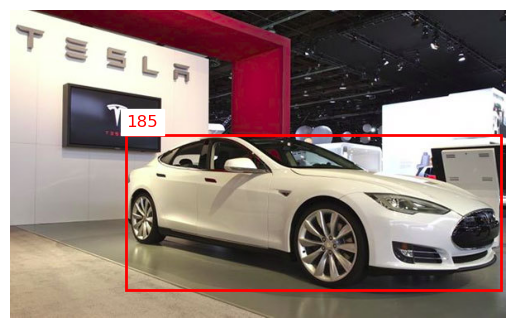

Displayed 5 test images with bounding boxes.


In [23]:

# Display images with bounding boxes
def display_image_with_bbox(image_path, annotation):
    # Load image
    img = Image.open(image_path)

    # Create plot
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding box
    x_min = row['Bounding Box coordinates_xmin']
    y_min = row['Bounding Box coordinates_ymin']
    x_max = row['Bounding Box coordinates_xmax']
    y_max = row['Bounding Box coordinates_ymax']
    image_class = row['Image class']
    bbox = annotation['bbox']
    rect = patches.Rectangle(
        (x_min, y_min),  # (x_min, y_min) -  (bbox[0], bbox[1])
        (x_max - x_min),   # width (x_max - x_min)  - bbox[2] - bbox[0]
        (y_max - y_min),   # height (y_max - y_min) -- bbox[3] - bbox[1]
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

    # Add class label
    plt.text(
        bbox[0], bbox[1] - 10,  # Position of the label
        annotation['image_class'],
        color='red',
        fontsize=12,
        backgroundcolor='white'
    )

    plt.axis('off')
    plt.show()


# for training images - Rewritten for displaying only five images
print("For Training Images") # Changed message to "Test Image"
displayed_image_count = 0  # Initialize a counter to track displayed images

image_paths_details_training=[]
images_paths_details_testing=[]

for index, row in train_image_annot_dir_file.iterrows():
    if displayed_image_count >= 5: # Check if we've already displayed two images
        break  # If yes, exit the loop

    image_name = str(row['Image Name']).strip()
    image_path = None # Initialize image_path to None


    for class_folder in train_class_folders:
        potential_image_path = os.path.join(class_folder, image_name)
        if os.path.exists(potential_image_path):
            image_path = potential_image_path
            image_paths_details_training.append(potential_image_path)
            break # Image found, no need to check other class folders

    if image_path: # If image_path is found (not None)
        annotation = {
            'bbox': [row['Bounding Box coordinates_xmin'], row['Bounding Box coordinates_ymin'], row['Bounding Box coordinates_xmax'], row['Bounding Box coordinates_ymax']],
            'image_class' : row['Image class']
        }
        display_image_with_bbox(image_path, annotation)
        displayed_image_count += 1 # Increment the counter
    #else:
    #    print(f"Training Image not found: {image_name}")

print(f"Displayed {displayed_image_count} training images with bounding boxes.")
#*****************************************************************************************

# for test images - Rewritten for displaying only two images (or adjust as needed)
print("For Testing Images") # Changed message to "Test Image"
displayed_image_count_test = 0  # Initialize a counter to track displayed images

for index, row in test_image_annot_dir_file.iterrows():  # Use test_annotations_df DataFrame
    if displayed_image_count_test >= 5: # Check if we've already displayed two images (adjust number here if you want 5 or more)
        break  # If yes, exit the loop

    image_name_test = str(row['Image Name']).strip()
    image_path_test = None # Initialize image_path_test to None

    for class_folder in test_class_folders: # Use test_class_folders
        potential_image_path_test = os.path.join(class_folder, image_name_test)
        if os.path.exists(potential_image_path_test):
            image_path_test = potential_image_path_test # Assigned to image_path_test
            images_paths_details_testing.append(potential_image_path)
            break # Image found, no need to check other class folders

    if image_path_test: # If image_path_test is found (not None)
        annotation_test = {
            'bbox': [row['Bounding Box coordinates_xmin'], row['Bounding Box coordinates_ymin'], row['Bounding Box coordinates_xmax'], row['Bounding Box coordinates_ymax']],
            'image_class' : row['Image class'] # Assuming 'Image class' column also exists in test_annotations_df (verify!)
        }
        display_image_with_bbox(image_path_test, annotation_test)  # Changed here
        displayed_image_count_test += 1 # Increment the counter
    #else:
    #    print(f"Test Image not found: {image_name_test}") # Changed message to "Test Image"

print(f"Displayed {displayed_image_count_test} test images with bounding boxes.") # Changed message to "test images"



# **Design, Train, and Test Basic CNN Models to Classify the Car**

In [24]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image for CNN input.
    """
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Warning: Image file not found: {image_path}")
        return None  # Or handle the missing image in a way that makes sense for your application

    image = cv2.imread(image_path)  # Load image

    # Check if image loading was successful
    if image is None:
        print(f"Warning: Failed to load image: {image_path}")
        return None  # Or handle the loading error as needed

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

In [25]:
def custom_generator(df, batch_size, target_size):
    """
    Custom generator for images and labels.
    """
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = df.iloc[offset:offset + batch_size]
            images = []
            labels = []
            for _, row in batch_samples.iterrows():
                image = preprocess_image(row['Image_Path'], target_size)
                label = row['label_categorical']
                images.append(image)
                labels.append(label)
            X = np.array(images)
            y = np.array(labels)
            yield X, y


In [26]:
# Apply preprocessing to all images
df_testing['image'] = df_testing['Image_Path'].apply(preprocess_image)
df_training['image'] = df_training['Image_Path'].apply(preprocess_image)

# Check for and handle None values in the 'image' column
df_testing = df_testing.dropna(subset=['image'])  # Remove rows with None in 'image'
df_training = df_training.dropna(subset=['image'])  # Remove rows with None in 'image'

In [27]:
# Encode labels
label_encoder = LabelEncoder()
df_testing['labels_encoded'] = label_encoder.fit_transform(df_testing['labels'])
df_training['labels_encoded'] = label_encoder.fit_transform(df_training['labels'])

# Convert labels to categorical (one-hot encoding)
df_testing['label_categorical'] = df_testing['labels_encoded'].apply(lambda x: to_categorical(x, num_classes=len(test_class_folders)))
df_training['label_categorical'] = df_training['labels_encoded'].apply(lambda x: to_categorical(x, num_classes=len(test_class_folders)))

In [28]:
# Create generators
batch_size = 32
train_generator = custom_generator(df_training, batch_size, target_size=(224, 224))
val_generator = custom_generator(df_testing, batch_size, target_size=(224, 224))

In [29]:
# Check training generator
X_batch, y_batch = next(train_generator)
print("Training batch shape:", X_batch.shape, y_batch.shape)

# Check validation generator
X_batch, y_batch = next(val_generator)
print("Validation batch shape:", X_batch.shape, y_batch.shape)

Training batch shape: (32, 224, 224, 3) (32, 196)
Validation batch shape: (32, 224, 224, 3) (32, 196)


#### **VGG Models**

In [30]:
#importing libraries
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


In [31]:
def build_vgg_model(model_type='VGG16', input_shape=(224, 224, 3), num_classes=196):
    if model_type == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_type == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freezing base model layers for pre-trained weights
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last 10 layers for fine-tuning
    for layer in base_model.layers[-10:]:
        layer.trainable = True
        
    # Adding custom layers on top
    x = Flatten()(base_model.output) # Flatten the feature maps into a single vector
    x = Dense(512, activation='relu')(x) # fully connected layer 
    x = Dropout(0.5)(x) #drop out to prevent overfitting
    x = Dense(num_classes, activation='softmax')(x) #output layer 
    
    model = Model(inputs=base_model.input, outputs=x)
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [32]:
vgg16_model = build_vgg_model(model_type='VGG16')
#vgg19_model = build_vgg_model(model_type='VGG19')

2025-03-02 19:06:37.457249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-02 19:06:37.459283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-02 19:06:37.461440: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [33]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
IMG_SIZE = (224, 224) # image size
BATCH_SIZE = 32 # batch size
NUM_CLASSES = 196 # car classes

In [35]:
train_dir = './car_data/car_data/train'
test_dir = './car_data/car_data/test'

#### **Performing Data Augmentation**

In [36]:
train_data_generation = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [37]:
train_generator = train_data_generation.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 8144 images belonging to 196 classes.


In [38]:
test_data_generator = ImageDataGenerator(rescale=1./255) 

In [39]:
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

Found 8041 images belonging to 196 classes.


In [40]:
vgg16_model_history = vgg16_model.fit(
        train_generator,
        validation_data=test_generator,  # Use test set for evaluation
        epochs=10,
        verbose=1
    )

Epoch 1/10


I0000 00:00:1740942412.232850   88763 service.cc:145] XLA service 0x7f8cb001bcb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740942412.232896   88763 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1740942412.232901   88763 service.cc:153]   StreamExecutor device (1): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1740942412.232904   88763 service.cc:153]   StreamExecutor device (2): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1740942412.232906   88763 service.cc:153]   StreamExecutor device (3): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1740942412.232908   88763 service.cc:153]   StreamExecutor device (4): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1740942412.232911   88763 service.cc:153]   StreamExecutor device (5): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1740942412.232913   88763 service.cc:153]   StreamExecutor device (6): NVIDIA A10G, Compute Capability 8.

255/255 [==============================] - 137s 451ms/step - loss: 5.3651 - accuracy: 0.0054 - val_loss: 5.2692 - val_accuracy: 0.0060
Epoch 2/10
255/255 [==============================] - 111s 434ms/step - loss: 5.2816 - accuracy: 0.0076 - val_loss: 5.2615 - val_accuracy: 0.0103
Epoch 3/10
255/255 [==============================] - 106s 416ms/step - loss: 5.2667 - accuracy: 0.0076 - val_loss: 5.2419 - val_accuracy: 0.0131
Epoch 4/10
255/255 [==============================] - 105s 411ms/step - loss: 5.2435 - accuracy: 0.0106 - val_loss: 5.1847 - val_accuracy: 0.0199
Epoch 5/10
255/255 [==============================] - 105s 412ms/step - loss: 5.1974 - accuracy: 0.0162 - val_loss: 5.0686 - val_accuracy: 0.0296
Epoch 6/10
255/255 [==============================] - 105s 413ms/step - loss: 5.1130 - accuracy: 0.0216 - val_loss: 4.9445 - val_accuracy: 0.0419
Epoch 7/10
255/255 [==============================] - 106s 416ms/step - loss: 5.0265 - accuracy: 0.0291 - val_loss: 4.7831 - val_accura

In [41]:
test_loss, test_acc = vgg16_model.evaluate(test_generator)


252/252 [==============================] - 23s 92ms/step - loss: 4.2778 - accuracy: 0.1077


In [42]:
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 10.77%
Test Loss: 4.2778


##### **Observation**
##### **The training accuracy is about 6% with a loss of 4.6** 
##### **The testing accuray is about 10% with a loss of 4.3**
##### **The model seems to be underperfoming and the accuracy seems to be low.**
##### **The model has scope for performance tuning, to check if the accuracy increases and loss decreases**